In [1]:
# AUTHOR: Torben Guijarro, CID:01984901

import sys, os, time
import numpy as np 
import scipy.io as io 
import matplotlib.pyplot as plt
from scipy.signal import correlate 
import pandas as pd
import seaborn as sb
import matplotlib.patches as mpatches
from matplotlib import colors
import networkx as nx
import math

In [2]:
# %% Load dataset, https://www.biorxiv.org/content/10.1101/2020.10.18.344184v1.abstract

# Should load behavioural data (x and y position, radial position and angle 
# phi in function of time fluorence time series dfonf -> provides a matric of 
# fluorescence intensities with matrix dimensions Cells x Time-Duration
datadir = 'datacw2/data/dataset3_m62/'
trackdata = io.loadmat(datadir+'downTrackdata.mat')
phi = trackdata['phi']; x = trackdata['x']; y = trackdata['y']; r=trackdata['r'];
speed = trackdata['speed']; t = trackdata['time'];
spikedata = io.loadmat(datadir+'spikes.mat') #loads data comme un dictionnaire python
spikes = spikedata['spikes'] 
params = spikedata['params']
fluodata = io.loadmat(datadir+'fissa_output.mat')
dfonf = fluodata['ddf_f']

In [29]:
# Functions used in coursework

# plot circular graph
def circleplot(Adj):
    import numpy as np
    import matplotlib.pyplot as plt
    nVertices = len(Adj[:,1])
    degree = np.sum(Adj,1)

    theta = np.linspace(0,2*np.pi,nVertices)
    x = np.cos((theta))

    y = np.sin((theta))
    
    plt.figure()
    plt.scatter(x,y)

    for i in range(nVertices):

        for col in range(i,nVertices):
            if (degree[i]>0):
                if (Adj[i,col]==1):

                    plt.plot([x[i],x[col]],[y[i],y[col]], linewidth=0.05, color = 'k')
    plt.title("All edges")
    plt.show
    plt.axis("equal")
    
def circleplotless(Adj,kcutoff):
    import numpy as np
    import matplotlib.pyplot as plt
    nVertices = len(Adj[:,1])
    degree = np.sum(Adj,1)

    theta = np.linspace(0,2*np.pi,nVertices)
    x = np.cos((theta))

    y = np.sin((theta))
    
    plt.figure()
    plt.scatter(x,y)

    for i in range(nVertices):

        for col in range(i,nVertices):
            if (degree[i]<kcutoff):
                if (Adj[i,col]==1):

                    plt.plot([x[i],x[col]],[y[i],y[col]], linewidth=0.05, color = 'k')
    plt.title("Degree less than %s " %kcutoff)
    plt.show
    plt.axis("equal")

def circleplotgreater(Adj,kcutoff):
    import numpy as np
    import matplotlib.pyplot as plt
    nVertices = len(Adj[:,1])
    degree = np.sum(Adj,1)

    theta = np.linspace(0,2*np.pi,nVertices)
    x = np.cos((theta))

    y = np.sin((theta))
    
    plt.figure()
    plt.scatter(x,y)

    for i in range(nVertices):

        for col in range(i,nVertices):
            if (degree[i]>kcutoff):
                if (Adj[i,col]==1):

                    plt.plot([x[i],x[col]],[y[i],y[col]], linewidth=0.05, color = 'k')
    plt.title("Degree greater than %s " %kcutoff)
    plt.show
    plt.axis("equal")
    
def circleplotsorted(Adj):
    import numpy as np
    import matplotlib.pyplot as plt
    nVertices = len(Adj[:,1])
    degree = np.sum(Adj,1)
    
    sortedVertices = np.argsort(degree)[::-1]
    theta = np.linspace(0,2*np.pi,nVertices)
    x = np.cos((theta))

    y = np.sin((theta))
    
    plt.figure()
    plt.scatter(x,y)

    for i in sortedVertices:
        if degree[i]>0:
            for col in range(i,nVertices):
                if (Adj[i,col]==1):
                    start = np.where(sortedVertices==i)[0]
                    end = np.where(sortedVertices == col)[0]
                    plt.plot([x[start],x[end]],[y[start],y[end]], linewidth=0.1, color = 'k')

    plt.title("Sorted by degree")
    plt.show
    plt.axis("equal")

# cluster coefficient
def clustercoeff(A): # A = adj matrix
    nVertices = len(A[1,:]) # can use A[:,1] instead, doesn't matter, square matrix
    nEdges = np.sum(A)/2 # number of edges, divided by 2 because it repeats in matrix
    degree = np.sum(A,1) 
    #print("Degree of each node is %s" % degree)
    avgDegree = sum(degree)/nVertices
    #print("Average degree is %s" % avgDegree)

    edges = []
    for vertex in range(nVertices): # pour chaque sommet parmis tout les sommets
        temp = [i for i, x in enumerate(A[vertex,:]) if x == True] # stocke tous les indices qui ont 1 (True)
        #print("Vertex %d is connected to vertices %s" % (vertex,temp))
        edges.append(list(temp)) # liste de n-liste ou la i-eme liste contient les vertex connectes entre eux
    # liste de 138 vertices ou le i-eme vertex contient tout les vertices qui lui sont rattachees
    # edges is a list of lists (connection matrix). 
    # each index_i of edges is a list that contains the index of vertices j that vertex i is connected to
    
    
    #print(edges)
    closedtriangles = []
    for vertex_i in range(nVertices): 
        count =0 # Reset the connections count
        #For each vertex_i
        if degree[vertex_i] <= 1: # looks if the degree is less than 1
            closedtriangles.append(0) # append. =  ajoute
        else:
            for layer1 in edges[vertex_i]: # for each cellj attached to a main celli
                #For the vertices that are connected to vertex_i (Layer 1)
                #print("V: ",vertex_i," Edges ",edges[vertex_i],"| Vertex ", layer1, " has connections to ",edges[layer1])
                for layer2 in edges[layer1]: # looks at the neighbours of the cellj 

                    if layer2 in edges[vertex_i]: # if neighbour of cellj is attached to celli

                    # if a vertex  in the first layer is connected to another vertex in the first layer (which is connected to vertex i)
                    # Then the triangle between vertex i and its primary connections is closed
                    # So increase the count of closed triangles by 1
                        count = count +1

            closedtriangles.append(count/2)    # Divide by two to prevent double counting
        
    
    nclosedtri = np.array(list(closedtriangles)) # nominator of clustering coeff
    
    # denominator of cluster coeff
    npossibletriangles = np.array(degree*(degree-1)/2) # calculate the # of possible triangles from each node

    out = nclosedtri/npossibletriangles
    for i in range(len(out)):
        if np.isnan(out[i]): #if there is an NaN value convert to 0
            out[i] = 0
          
    return out # cluster coefficient is given by the ratio of closed triangles divided by the total number of possible closed triangles

# Poisson distribution
def poisson(meank,k):
    return meank**k * math.exp(-1*meank)/math.factorial(k)

# binomial distribution
def binomial(N,k,p):
    return math.factorial(N-1)/(math.factorial(k)*math.factorial(N-1-1))* p**k * (1-p)**(N-1-k)

# Question 1
Plot, as a square image, the matrix of Pearson correlation coefficients between the calcium fluorescence time series from each cell. Use a colour code that ranges from -1 to 1. Label your axes. 

In [12]:
# To consider the lines as vector. To compare the cell lines 
# as vectors and not value by value.
Tdf = dfonf.transpose() 

In [13]:
df = pd.DataFrame(Tdf)
# df.head()

# Pearson correlation 
pearsoncorr = df.corr(method='pearson') #df.corr does not consider the NaN values! check we don't have any NaN values
pearsoncorr

,0,1,2,3,4,5,6,7,8,9,...,128,129,130,131,132,133,134,135,136,137
0,1.000000,-0.139755,-0.030903,-0.194728,0.211573,-0.109795,0.101727,0.125349,0.019290,0.231334,...,0.110649,0.017770,0.182194,0.083977,0.043932,-0.090730,-0.120074,-0.081385,-0.052068,-0.145108
1,-0.139755,1.000000,-0.054954,0.586186,-0.129764,0.364119,0.160851,-0.044790,-0.017081,-0.248352,...,-0.094655,-0.102856,-0.128468,0.276673,-0.037433,0.088470,-0.040213,0.098154,-0.085361,0.017210
2,-0.030903,-0.054954,1.000000,-0.009432,0.003332,0.021973,0.038666,-0.011021,0.012808,0.017883,...,-0.064493,0.041869,-0.015941,-0.059549,0.209935,0.062752,-0.002086,0.028078,0.129548,-0.006323
3,-0.194728,0.586186,-0.009432,1.000000,-0.079724,0.209757,0.116151,-0.014640,0.147185,-0.256283,...,-0.027004,-0.113974,-0.129844,0.161649,-0.039954,-0.029867,0.074330,0.060876,-0.150469,0.036586
4,0.211573,-0.129764,0.003332,-0.079724,1.000000,0.110100,0.220269,-0.164803,0.087284,0.065091,...,0.361451,0.103239,0.111185,-0.023570,-0.050922,-0.062693,0.001234,-0.137290,-0.015698,-0.026261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,-0.090730,0.088470,0.062752,-0.029867,-0.062693,0.205148,0.106024,-0.139913,-0.030749,-0.087979,...,0.018900,-0.103383,-0.196128,0.055999,0.023232,1.000000,-0.006154,0.145768,0.114939,-0.014564
134,-0.120074,-0.040213,-0.002086,0.074330,0.001234,-0.017254,-0.037460,-0.030937,0.064570,0.004109,...,-0.026849,0.121095,0.072567,-0.113604,-0.009767,-0.006154,1.000000,0.006633,0.083967,0.175921
135,-0.081385,0.098154,0.028078,0.060876,-0.137290,0.053333,0.023063,-0.001669,0.062335,-0.065011,...,-0.084263,-0.051136,-0.022176,0.056155,-0.015872,0.145768,0.006633,1.000000,-0.000535,0.005573
136,-0.052068,-0.085361,0.129548,-0.150469,-0.015698,-0.083286,-0.079389,-0.082395,-0.010750,0.049303,...,-0.078599,0.136132,0.094997,-0.095194,0.197342,0.114939,0.083967,-0.000535,1.000000,0.150990


Text(410.0, 0.5, 'cell number')

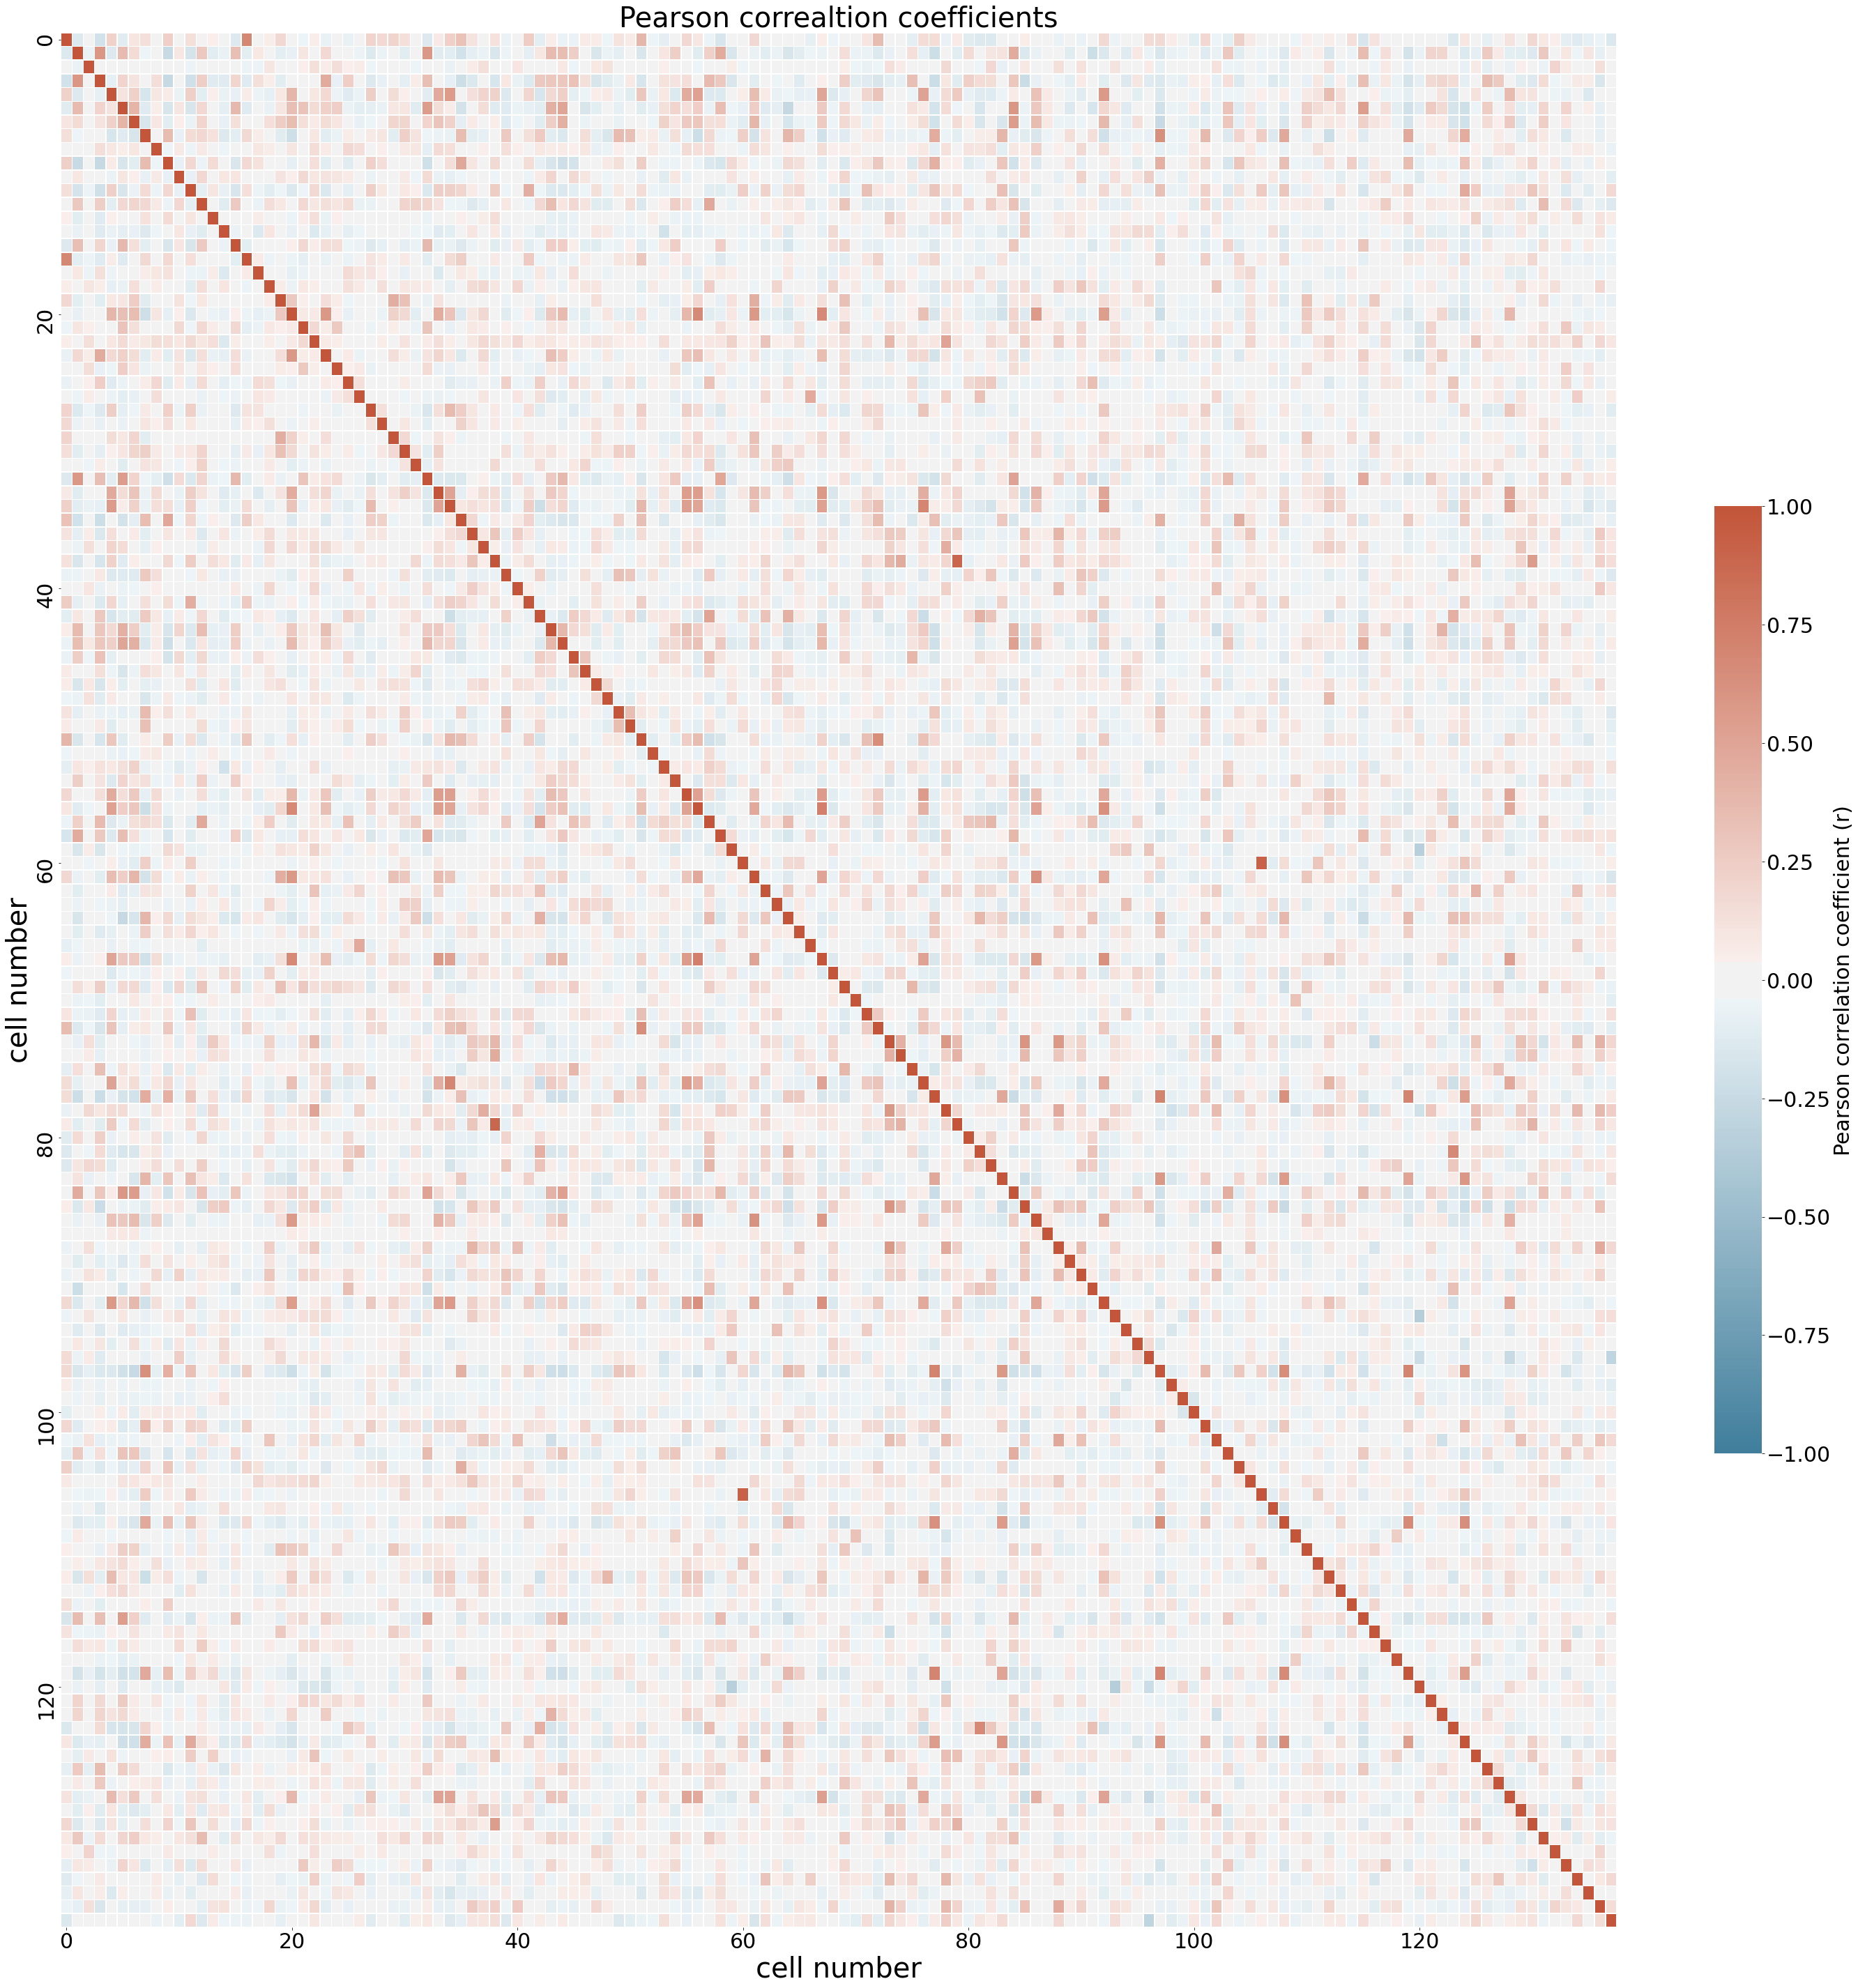

In [14]:
# Matrix of Pearson correlation as a heatmap

# Generate a custom diverging colormap
cmap = sb.diverging_palette(230, 20, as_cmap=True)

# Font size axis
plt.rcParams.update({'font.size': 30})

# Plotting heatmap
plt.figure(1, figsize=(50,50))
sb.heatmap(pearsoncorr, 
            vmax = 1,
            vmin = -1,
            xticklabels=20, 
            yticklabels=20,
            cmap=cmap,
            #cmap='RdBu_r',
            annot=False,
            linewidth=0.5,
            cbar_kws={'label': 'Pearson correlation coefficient (r)', "shrink": .5})
plt.title('Pearson correaltion coefficients', fontsize=40)
plt.xlabel('cell number', fontsize=40)
plt.ylabel('cell number', fontsize=40)


For a better visualisation of the values we will also plot the Pearson correlation upper triangle matrix matrix 

Text(230.0, 0.5, 'cell number')

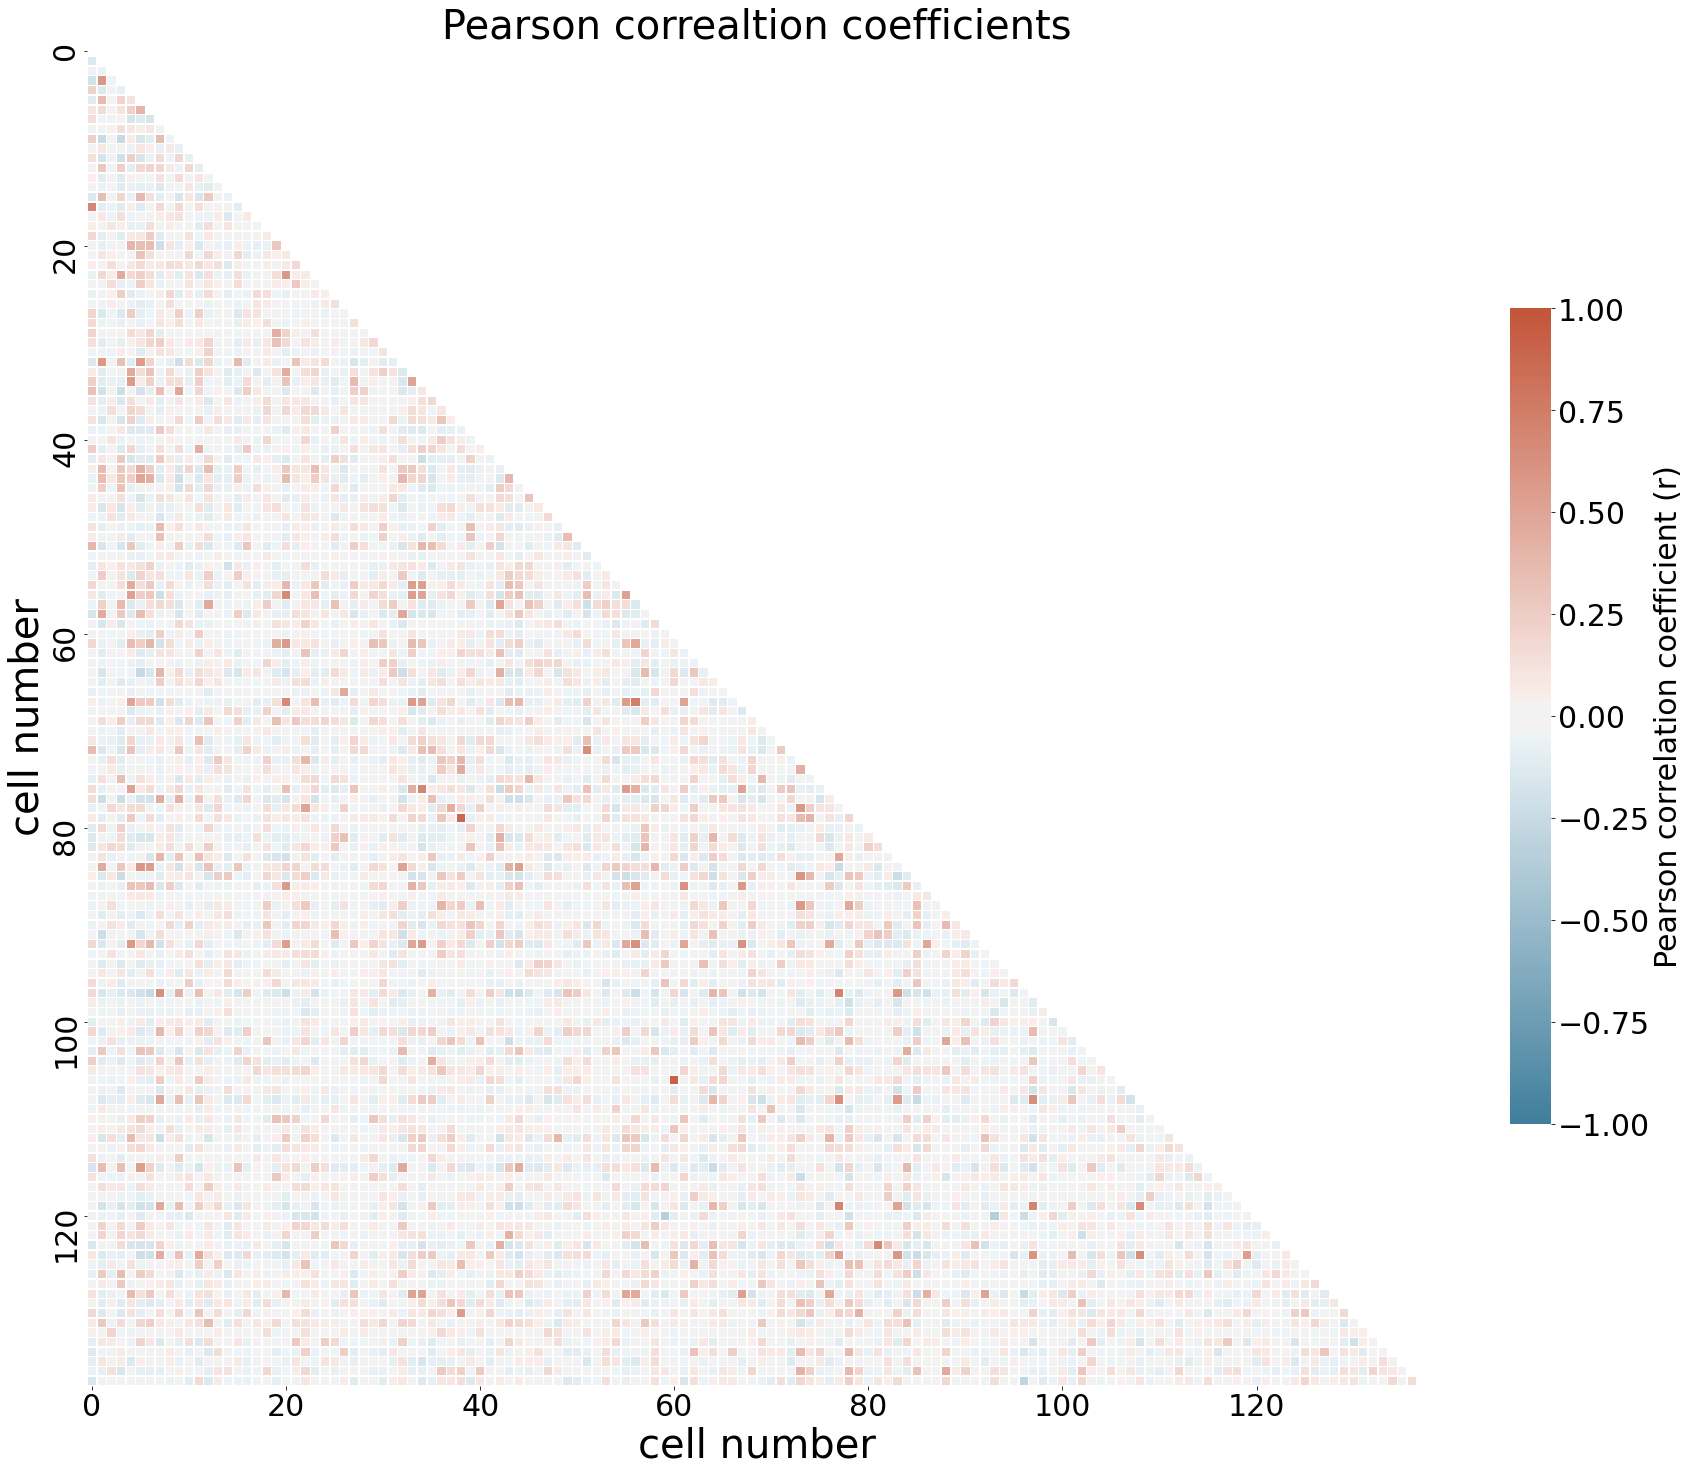

In [15]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(pearsoncorr, dtype=bool))

# Set up the matplotlib figure
plt.figure(2, figsize=(30,30))
plt.xlabel('cell number')
plt.ylabel('cell number')

# Generate a custom diverging colormap
cmap = sb.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plt.title('Pearson correaltion coefficients', fontsize=40)
plt.xlabel('cell number', fontsize=40)
plt.ylabel('cell number', fontsize=40)
sb.heatmap(pearsoncorr, 
           mask=mask, 
           cmap=cmap, 
           vmax=1,
           vmin=-1,
           xticklabels=20,
           yticklabels=20,
           center=0,
           square=True, 
           linewidths=.5, 
           cbar_kws={'label': 'Pearson correlation coefficient (r)', "shrink": .5})
plt.title('Pearson correaltion coefficients', fontsize=40)
plt.xlabel('cell number', fontsize=40)
plt.ylabel('cell number', fontsize=40)

The above matrix represents the Pearson correlation coefficients (r) of the calcium time series between each cell. The values vary from -1 to 1. The closer the correlation coefficient is to -1 or 1 the more linearly correlated (negatively or positively)  are the cells. A value of r=0 implies no linear correlation. For visualisation purposes a heatmap was plotted with a diverging colormap showing positive correlations in a range of red and negative correlations in a range of blue. Furthermore, a second plot showing only the lower triangle of the matrix was displayed. From the above matrices we can see overall poor correlation coefficients, some negatively and in its majority some strong positive correlations. A correlation coefficient is considered strong if its value is above 0.5. 

Some strong (positive) correlation can be expected from CW1 as the Principal Component Analysis (PCA) showed a relationship of the cells fluorescency and the angular position of the mouse. Therefore, we can observe some high degree correlation coefficients when cells in the same region were activated. 

### Q1
Now plot the distribution of correlation coefficients.

We only used the upper triangle matrix's values has we don't want to repeat values. Furthermore, we plotted all the Pearson correlation coefficients for another visualisation of its distribution.

In [16]:
# selecting upper matrix of pearsoncorr matrix
d_size = len(pearsoncorr)
data = pearsoncorr.to_numpy() # converting pandas to numpy
data = data[np.triu_indices(d_size,k=1)] #takes only the upper part of matrix

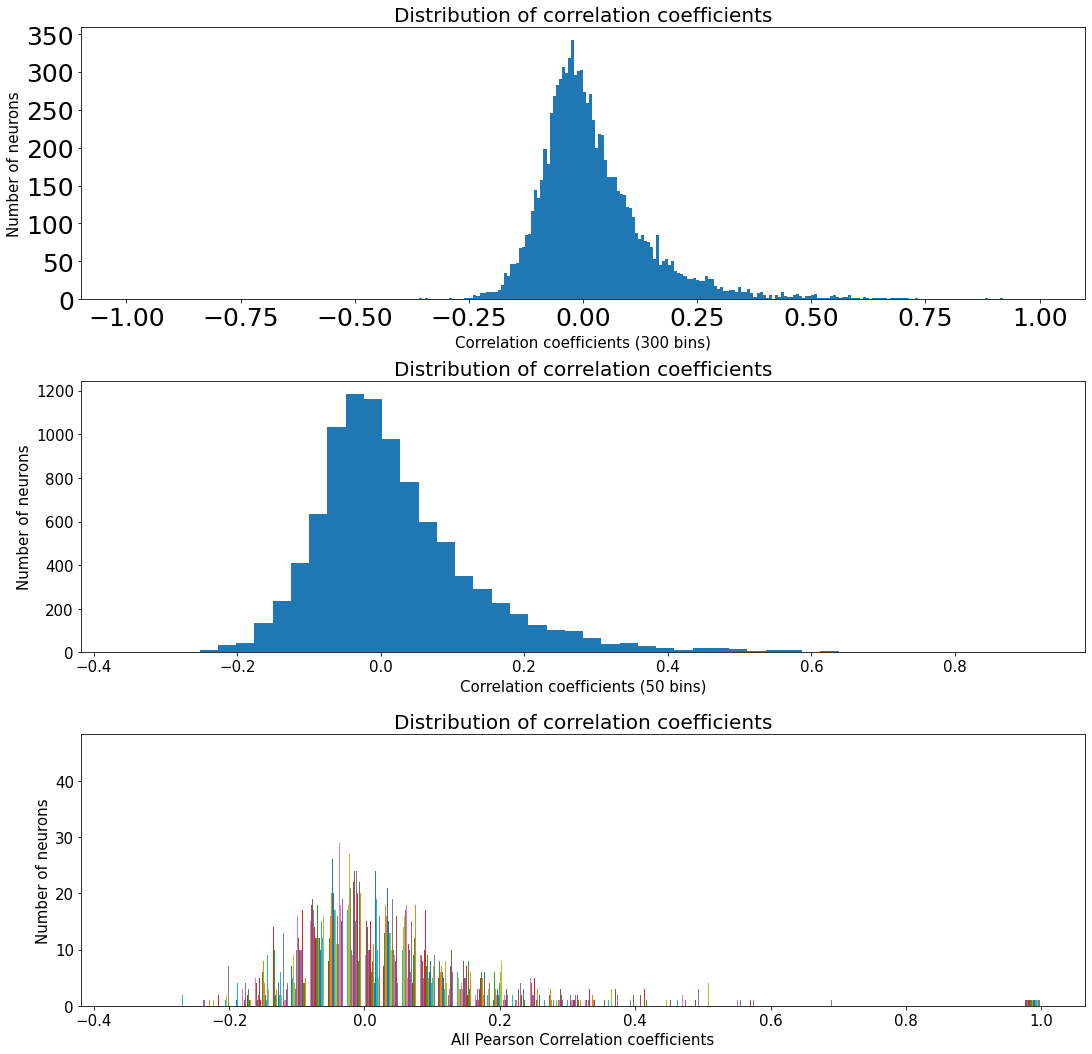

In [17]:
# Plotting the distribution of the correlation coefficients

# General, with boundaries -1, 1
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(18,18))
plt.clf()
plt.subplot(3,1,1)
plt.rcParams.update({'font.size': 15})
plt.xlabel('Correlation coefficients (300 bins)', fontsize=15)
plt.ylabel('Number of neurons', fontsize=15)
plt.title('Distribution of correlation coefficients', fontsize=20)
hist, bins, _ = plt.hist(data.flatten(), bins=300, density=False, range=(-1, 1))

plt.subplots_adjust(hspace=0.3)

# Zoomed
plt.subplot(3,1,2)
plt.xlabel('Correlation coefficients (50 bins)', fontsize=15)
plt.ylabel('Number of neurons', fontsize=15)
plt.title('Distribution of correlation coefficients', fontsize=20)
hist, bins, _ = plt.hist(data.flatten(), bins=50, density=False)

# Plot of all the correlations, for better understanding
plt.subplot(3,1,3)
plt.xlabel('All Pearson Correlation coefficients', fontsize=15)
plt.ylabel('Number of neurons', fontsize=15)
plt.title('Distribution of correlation coefficients', fontsize=20)
hist, bins, _ = plt.hist(pearsoncorr, bins=50, density=False)

We decided to only plot the values of the upper matrix so no values are repeated in our distribution plot. Furthermore, we did not include the autocorrelation coefficients of the diagonal (ones).
The distribution of correlation coefficients confirms the observations made for the adjacency matrix. Most of the cells are uncorrelated as most of the peaks of the histogram are around 0. Nevertheless, a longer right tail of the histogram confirms that overall, there are more positive correlations than negative. 

### Q1
Form an undirected graph, with nodes representing each neuron, and edges a binary variable which is 1 if the correlation coefficient between the time series exceeds the 80th percentile of the distribution of correlation coefficients between different neurons. Do not allow self-edges. Plot the adjacency matrix for the graph as an image. Also plot it using another graph visualisation method.

In [18]:
# We find the 80th percentile by removing the diagonal 
# from the correlations.
data_np = pearsoncorr.to_numpy()
nVerts = len(data_np)
corr = [data_np[i,j] for i in range(nVerts) 
                     for j in range(nVerts)  if i != j]    
pr = np.percentile(corr, 80)
print('The 80th percentile is: ', pr)

The 80th percentile is:  0.09323976346590593


In [19]:
# We create and Adjacency matrix of correlations

# Need to form a matrix of two columns with each node and its 
# number of edges.
# Matrix (138,138), nodes reprensent each neuron (cell line),
# Edges (0 or 1) depending if the value is above 80% of distribution
# correlation coeff

data_np = pearsoncorr.to_numpy()
nVerts = len(data_np) #there are 138 lines (=138 cells)
# we create a matrix 138,138 which reprensents all the nodes (vertices)
udAdj = np.zeros([nVerts,nVerts])

# now we need to fill in the matrix with 0 or 1 depending on its correlation coefficient
for i in range(nVerts):
    # find the 80th percentile for each cell
    # pr = np.percentile(data_np[i], 80)
    # print('pr is ',pr)
    for j in range(i+1,nVerts): # i+1 because of symmetry ?
        #if i!=j:
        if i!=j and data_np[i,j] > pr: 
                udAdj[i,j] = 1
                udAdj[j,i] = 1                
print("udAdj is ", udAdj)
print('pr is ', pr)

udAdj is  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]
pr is  0.09323976346590593


1890.0  undirected non-self edges and  138  vertices.
Average degree is  27.391304347826086


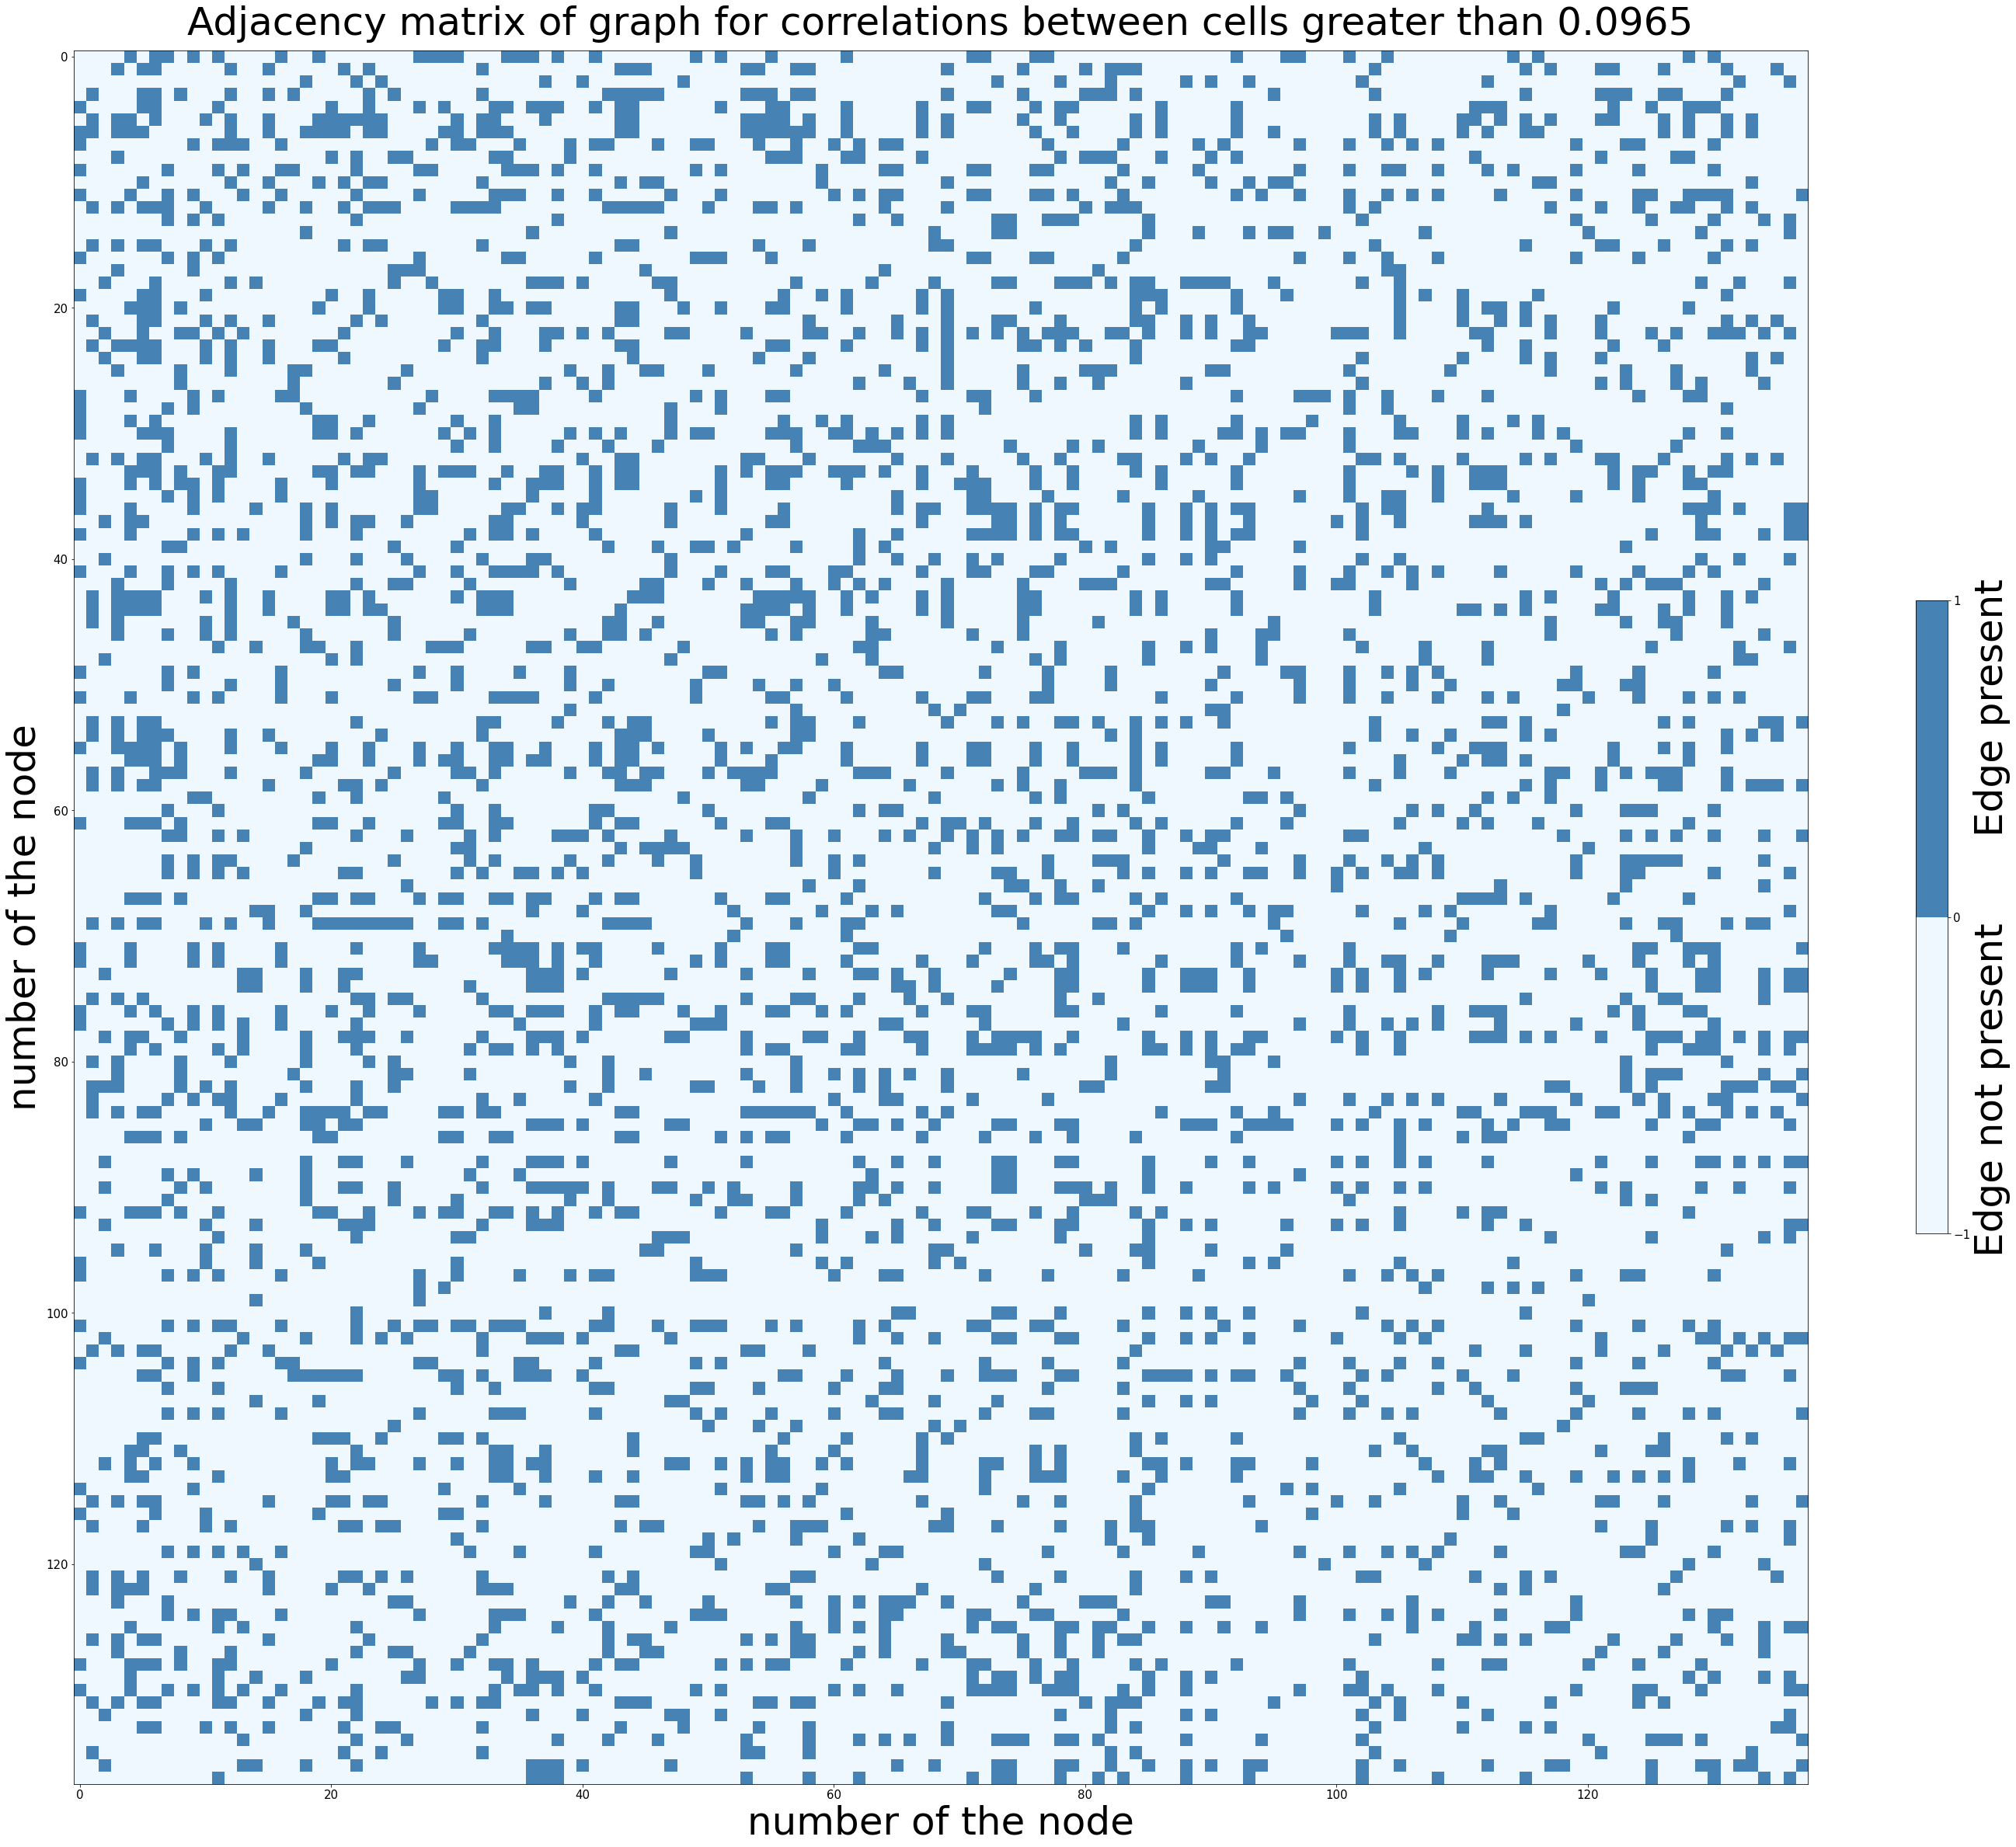

In [20]:
# Plotting the adjency matrix as an image and other method

plt.figure(figsize=(50,50))
#plt.imshow(udAdj, cmap=cmap, interpolation='none')
plt.title('Adjacency matrix of graph for correlations between cells greater than 0.0965', fontsize=50, pad=20)
plt.xlabel('number of the node', fontsize=50)
plt.ylabel('number of the node', fontsize=50)


cmap = colors.ListedColormap(['aliceblue', 'steelblue'])
bounds = [-1,0,1]
img = plt.imshow(udAdj, cmap=cmap, interpolation='none')
cbar = plt.colorbar(img, shrink=0.3, boundaries=bounds, ticks=[-1, 0, 1])
cbar.set_label('Edge not present       Edge present', fontsize=50)


nEdges = np.sum(udAdj)/2

nVertices = len(udAdj[1,:])

degree = np.sum(udAdj,1)

avgDegree = np.sum(degree)/nVertices

print(nEdges," undirected non-self edges and ", nVertices, " vertices.")

print("Average degree is ",avgDegree)


The adjacency matrix plot shows all the edges that have a Pearson correlation coefficient above the 80th percentile of all of them. Due to the amount of edges we cannot consider the matrix as sparse. 

(-1.0997239429241432,
 1.0999868544249591,
 -1.099927696961035,
 1.099927696961035)

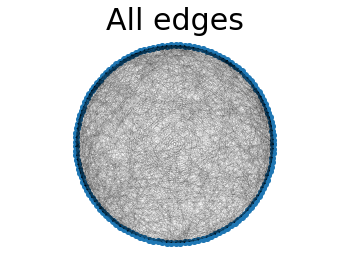

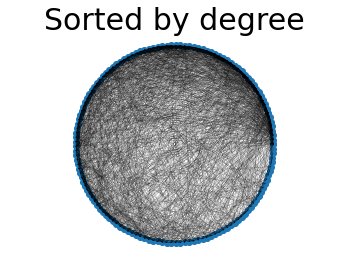

In [58]:
# Plotting circular graph
circleplot(udAdj)
plt.axis('off')
circleplotsorted(udAdj)
plt.axis('off')

The circular plots represent the nodes ordered by the number of the neurons first plot) and the nodes ordered by the nodes degree. From the the first plot we can observe that some nodes (~10) have a little higher degree than the others. This will further be analysed in the next questions. Furthermore, the large amount of edges, suggest the network is dense rather than sparse.

# Question 2
What is the average degree k for the network described by the above adjacency matrix? 
What is the global average clustering coefficient? 
Is this high compared to what you might expect for a random network? What is the network diameter D? Would you describe this network as “Small World”?

In [62]:
# Number of degrees for each cell (line)
degree = np.sum(udAdj,1)
#print("Degree of each node is %s" % degree)
avgDegree = sum(degree)/nVerts
print("Average degree of the network is %s" % avgDegree)
#mean = np.mean(degree)
#print('mean', mean)

Average degree of the network is 27.391304347826086


In [66]:
# Calculate the global clustering coefficient
CC = clustercoeff(udAdj)
print("Global average clustering coefficient ",np.sum(CC)/nVertices )
#mean = np.mean(CC)
#print('Global average clustering coefficient ', mean)
variance = np.var(CC)
print('Variance of Global average clustering coefficient ', variance)

Global average clustering coefficient  0.48004710700058717
Variance of Global average clustering coefficient  0.012303219246759586


<ipython-input-29-1d39ae9ecd1b>:153: RuntimeWarning: invalid value encountered in true_divide
  out = nclosedtri/npossibletriangles


In an $Erd\tilde o s-R\acute e nyi$ network with no self edges, all the edges have a homogeneous probability of existing $ p= \frac{\bar k}{(N-1)} $, where $\bar k$ the average degree of the nodes and N the number of nodes.The clustering coefficient of a node is $ C= \frac{2n}{k(k-1)} $ ,  where k is the degree of the node and n is the number of connected edges within the k nodes. The graph is undirected so for k connected edges the expected n is $ \bar n = \frac{p\bar k (\bar k -1)}{2} $. Therefore the expected clustering coefficient is $ \bar C = \frac{2p \bar k (\bar k-1)/2}{\bar k (\bar k -1)} = p $. 

In [67]:
# Comparing to a random network
G = nx.from_numpy_array(udAdj)
n_connected = len(list(nx.connected_components(G))[0]) #number of connected components
# compared to random network
avg_cl = avgDegree/n_connected
print('Expected clustering coefficients ', avg_cl) # average degree

Expected clustering coefficients  0.1984877126654064


If the network was E-R, the resultant expected clustering coefficient is much lower than the actual global clustering coefficient (0.47 vs 0.20). Furthermore, the variance of the cluster coefficients are not explanatory.

In [26]:
# Network diameter
D = nx.algorithms.distance_measures.diameter(G)
print('Diameter is: {}'.format(D))
#Avg = nx.average_neighbor_degree(G)
#print('Average degree is: {}'.format(D))

Diameter is: 4


Given the high cluster coefficient (higher when compared to expected from a random network) and the small network diameter, we can consider this network to be a Small World Network. 

# Question 3
Plot the degree distribution for the network.

$Erd\tilde o s-R\acute e nyi$ networks have a binomial degree distribution that can be approximated by a Poisson degree distribution with mean $\bar k$

In [40]:
# Overlay the histogram with a Poisson distribution with the same mean
# x = np.array(range(0,50))
max_degree = int(np.amax(degree))
                 
# Poisson distribution
poi = [poisson(avgDegree,k) for k in range(max_degree)]
#print(poi)

# Binomial distribution
boi = [binomial(n_connected,k,avg_cl) for k in range(max_degree)]
#print(boi)

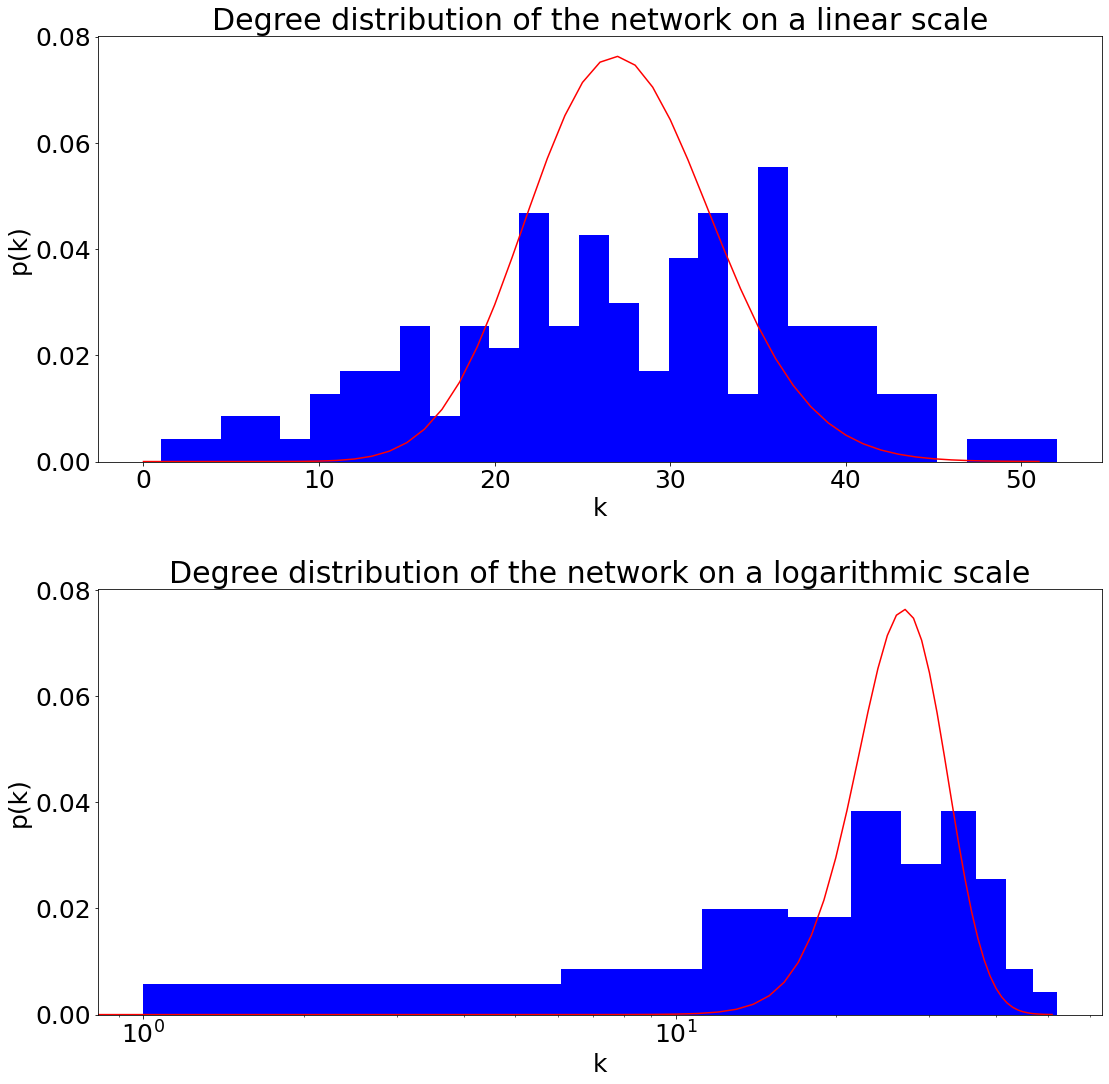

In [71]:
# Plotting the degree distribution for the network

plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(18,18))
plt.clf()
# plotting linear histogram
plt.subplot(2,1,1)
    # with Poisson distribution
plt.plot(range(max_degree), poi, color='r', label='Poisson distribution')
    # with Binomial distribution
#plt.plot(range(max_degree), boi, label='Binomial distribution')
plt.hist(degree, color='b', bins=30, density=True)
plt.title('Degree distribution of the network on a linear scale', fontsize=30)
plt.xlabel('k',fontsize=25) 
plt.ylabel('p(k)', fontsize=25)

plt.subplots_adjust(hspace=0.3)

# plotting logarithmic histogram
#logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
plt.subplot(2,1,2)
    # with Poisson distribution
plt.plot(range(max_degree), poi, color='r', label='Poisson distribution')
    # with Binomial distribution
#plt.plot(range(max_degree), boi, label='Binomial distribution')
#plt.hist(degree, color='b', bins=logbins, density=True)
plt.hist(degree, color='b', density=True)
plt.title('Degree distribution of the network on a logarithmic scale', fontsize=30)
plt.xscale('log')
plt.xlabel('k',fontsize=25) 
plt.ylabel('p(k)', fontsize=25)
plt.show()

When we contrast an E-R network to a Scale-free Network we tend to compare the tail of the distribution of the degree for high numbers of k. However, this network does not show a large number of nodes, thus no long tail. Therefore it is difficult to observe the characteristics of the tail. Nevertheless,  we observe that the distribution (especially Poisson distribution) is peaked around $\bar k$ (~27) followed by a rapid fall off. This is not very visible from the histogram but rather from the Poisson approximation. This might be due to highly connected hubs, as the fall off is slow. 
Nevertheless, while Scale-free networks have a power law degree distribution this is not clearly observed in our plots (there is not straight line in the log scale). Some nodes are more connected than the average but the network is too small to observe the features mentioned.  
To conclude, our network does not present significant features characteristic of a Scale-free network.